# Logistic Regression and Classification Error Metrics
![LogRegr.png](Assets/LogRegr.png)


# Learning Objectives

- Describe Logistic regression and how it differs from linear regression
- Identify metrics for classification errors and scenarios in which they can be used
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware


# scikit-learn*

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written.

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed.

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems.

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code PRIOR to importing sklearn:

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

Alternatively the same data set can be found at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip
The train file can be renamed as Human_Activity_Recognition_Using_Smartphones_Data.csv

For each record in the dataset it is provided:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.

More information about the features is available on the website above.

In [ ]:
import sklearn
from __future__ import print_function
import os
data_path = ['/content/']


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [ ]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [ ]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [ ]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [ ]:
data.iloc[:, :-1].min().value_counts()

-1.000000    243
-0.999504      4
-0.999999      3
-0.993886      2
-0.937244      2
            ... 
-0.999950      1
-0.999783      1
-0.999874      1
-0.828061      1
-0.980143      1
Length: 297, dtype: int64

In [ ]:
data.iloc[:, :-1].max().value_counts()

1.000000    143
0.510146      4
0.992169      2
0.809323      2
0.567757      2
           ... 
0.258656      1
0.041479      1
0.654685      1
0.447247      1
0.488889      1
Length: 401, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [ ]:
data.Activity.value_counts()

STANDING              615
LAYING                612
WALKING               609
SITTING               560
WALKING_UPSTAIRS      509
WALKING_DOWNSTAIRS    458
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

3097    1
760     0
852     2
1942    1
662     4
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [ ]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN

# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

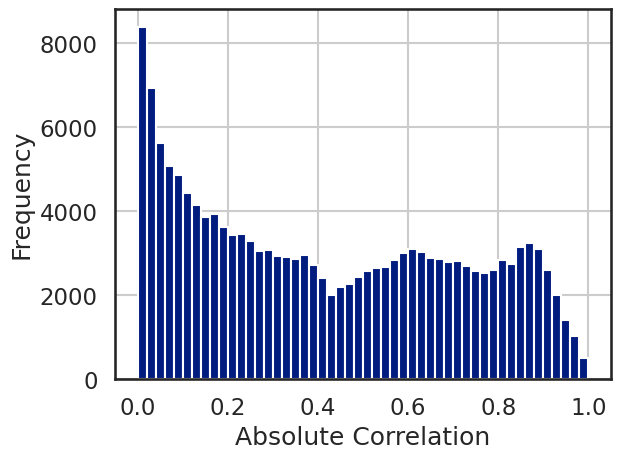

In [ ]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [ ]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
92104,tBodyAccMag-mean(),tBodyAccMag-sma(),1.000000,1.000000
95667,tBodyAccMag-arCoeff()2,tGravityAccMag-arCoeff()2,1.000000,1.000000
105403,tBodyGyroMag-mean(),tBodyGyroMag-sma(),1.000000,1.000000
93189,tBodyAccMag-max(),tGravityAccMag-max(),1.000000,1.000000
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.992665,0.992665
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994167,0.994167
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.995558,0.995558
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.995685,0.995685


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

data['Activity'].value_counts()
data = data[data['Activity'].isin(data['Activity'].value_counts()[data['Activity'].value_counts() > 1].index)]

!pip install imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(data[feature_cols], data.Activity)


# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))


# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [ ]:
y_train.value_counts(normalize=True)

2    0.183093
0    0.181818
3    0.180969
1    0.166525
5    0.151232
4    0.136364
Name: Activity, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.182359
2    0.182359
3    0.181368
1    0.166501
5    0.151635
4    0.135778
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(C=.001, max_iter=295).fit(X_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [ ]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=1, cv=4, penalty='l2').fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [ ]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
383 -0.004692 -0.005953 -0.006278  0.004729  0.020421 -0.008227  0.0   
413 -0.000956 -0.001175 -0.001220  0.000740  0.007044 -0.004434  0.0   
542 -0.005484 -0.009575 -0.008740  0.021222  0.009548 -0.006972  0.0   
42   0.064038  0.000940 -0.041770 -0.009315  0.001220 -0.015113  0.0   
96  -0.005471 -0.006775 -0.007163 -0.009199  0.034593 -0.005985  0.0   
44  -0.000642  0.007344 -0.001985 -0.006176  0.000256  0.001204  0.0   
248  0.001333  0.006301 -0.012317  0.022000  0.019572 -0.036888  0.0   
203 -0.012363 -0.015946 -0.023417 -0.017276  0.056030  0.012973  0.0   
299  0.003142  0.006518  0.007707 -0.018736 -0.020652  0.022021  0.0   
222  0.004230  0.006037  0.002925  0.030762 -0.015644 -0.028311  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
383  0.000000  0.000000 -0.291878  0.193943 -0.427694 -0.002371 -0.002401   
413  0.121400  0.193098  0.084968  0.145440  0.071701 -0.000499 -0.000510   
542  0.000000  0.000000  0.126682 -0.360715  0.230038 -0.003254 -0.003676   
42   0.000000 -5.918773  0.000000  0.000000 -0.555906  0.015027 -0.000145   
96   0.000000  0.000000 -0.359652  0.000000 -0.318282 -0.002693 -0.002714   
44   0.524240  0.494041  0.364175 -0.032757  0.113366 -0.000265  0.000697   
248 -0.806654  2.579274  0.915992  0.000000  0.622938  0.000413  0.000906   
203  0.000000  0.000000 -1.191934  0.000000  0.761418 -0.006905 -0.007139   
299  0.000000  0.548077  0.037043 -0.037799  0.721408  0.001887  0.001924   
222  0.000000  1.019117  1.174887  0.000000 -2.125602  0.002413  0.002700   

                                             
            2         3         4         5  
383 -0.002573  0.002614  0.005594 -0.000863  
413 -0.000544  0.000228  0.001771 -0.000445  
542 -0.003753  0.005606  0.004982  0.000094  
42  -0.006537 -0.002966 -0.001169 -0.004210  
96  -0.002906  0.000341  0.008165 -0.000194  
44  -0.000361 -0.000830  0.000177  0.000581  
248 -0.001977  0.003564  0.004298 -0.007203  
203 -0.008360  0.002363  0.014343  0.005697  
299  0.002226 -0.004428 -0.004856  0.003247  
222  0.001931  0.002869 -0.003441 -0.006473

Prepare six separate plots for each of the multi-class coefficients.

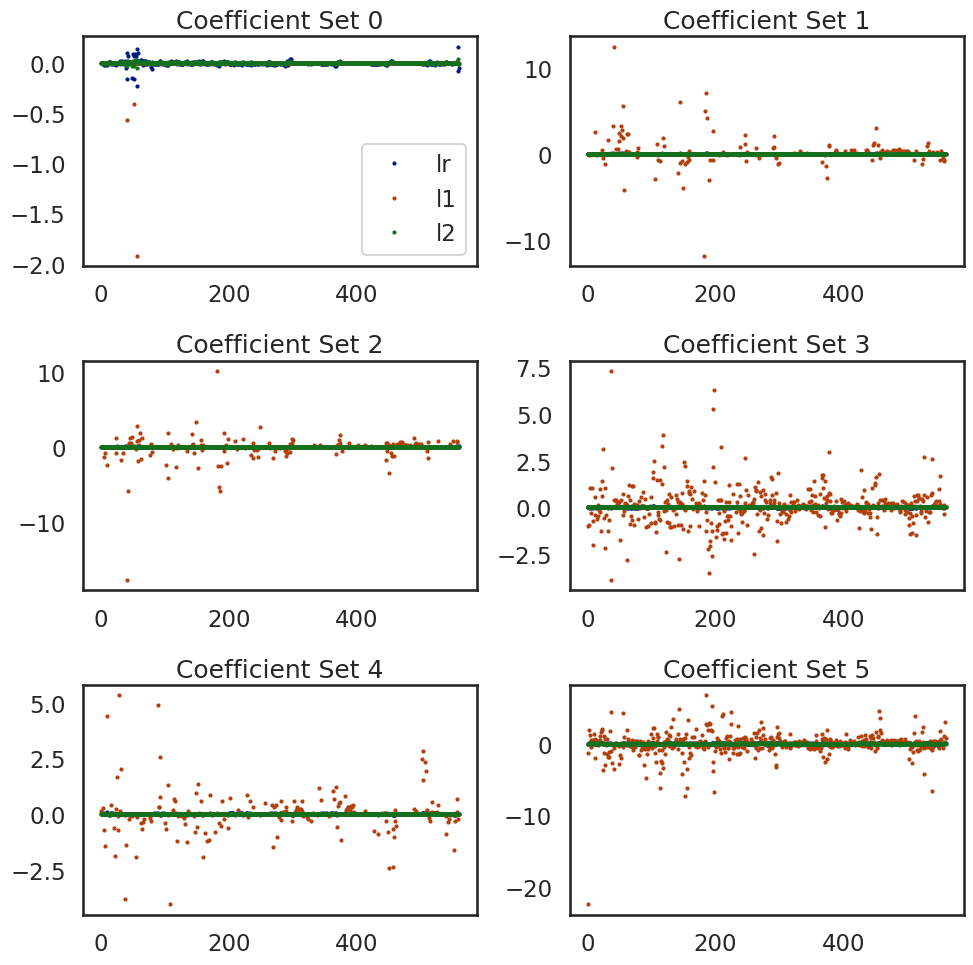

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)

    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model.

In [ ]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,2,1,2
1,5,5,3
2,0,0,0
3,3,3,3
4,2,1,2


In [ ]:
y_prob.head()

,lr,l1,l2
0,0.472351,0.560892,0.294842
1,0.441029,0.866418,0.223272
2,0.809451,1.000000,0.379045
3,0.543413,0.935549,0.326442
4,0.446029,0.910900,0.282158


## Question 7

For each model, calculate the following error metrics:

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])

    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
              average='weighted')

    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc},
                             name=lab))

metrics = pd.concat(metrics, axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.893690,0.980209,0.650989
recall,0.888008,0.980178,0.657086
fscore,0.886388,0.980183,0.584124
accuracy,0.888008,0.980178,0.657086
auc,0.931971,0.988006,0.790434


## Question 8

Display or plot the confusion matrix for each model.

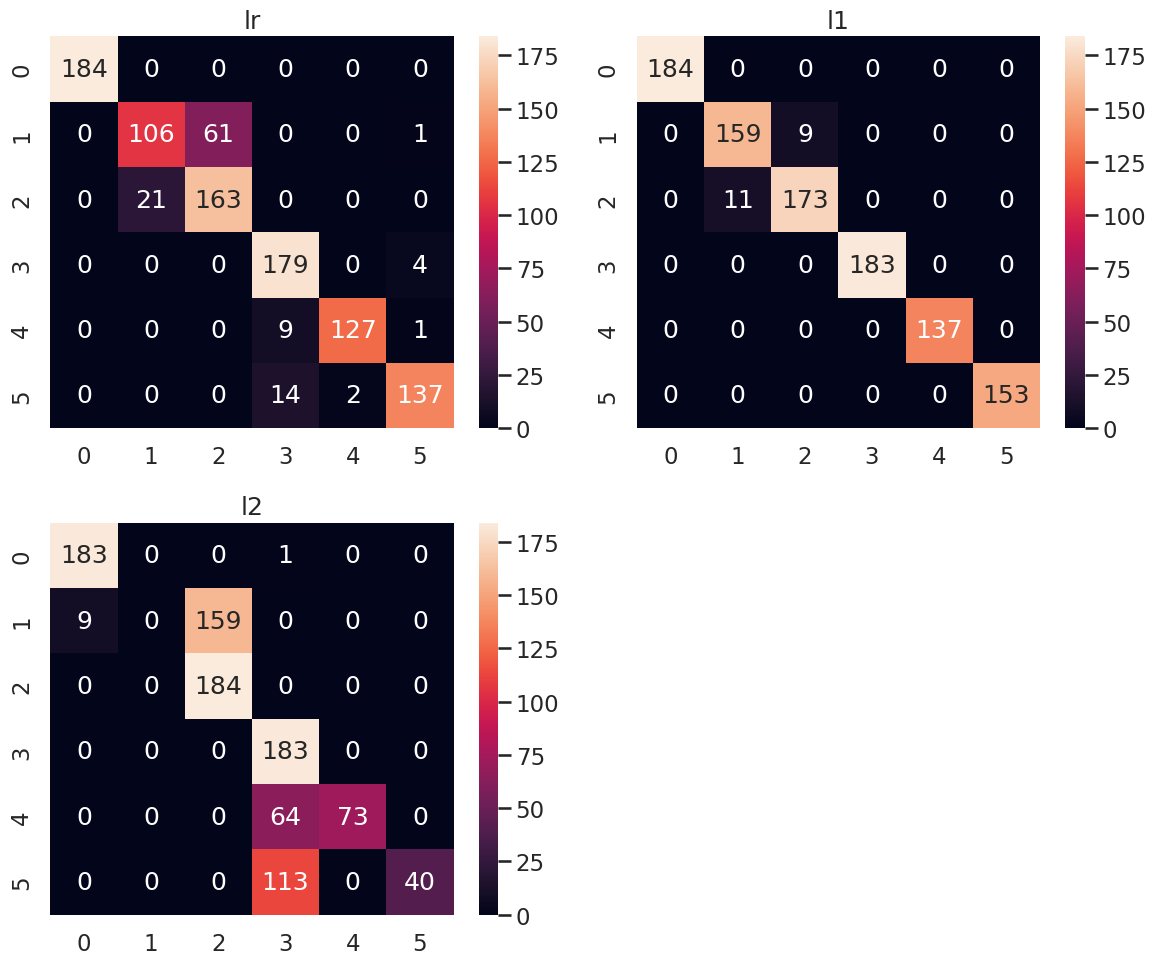

In [ ]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

 Repeat Model building with new training data after removing higly correlated columns

In [ ]:
# Try standard, L1 and L2 Logistic regression
data_path = ['/content/']
filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [ ]:
data.dtypes.value_counts()

float64    11
int64       9
dtype: int64

In [ ]:
data.dtypes.tail()

total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churned                            int64
dtype: object

In [ ]:
data.iloc[:, :-1].min().value_counts()

0.0      14
1.0       1
408.0     1
dtype: int64

In [ ]:
data.iloc[:, :-1].max().value_counts()

20.00     2
243.00    1
510.00    1
52.00     1
351.50    1
165.00    1
59.76     1
363.70    1
170.00    1
30.91     1
395.00    1
175.00    1
17.77     1
5.40      1
9.00      1
dtype: int64

In [ ]:
data.churned.value_counts()

0    4293
1     707
Name: churned, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['churned'] = le.fit_transform(data.churned)
data['churned'].sample(5)

741     0
4435    0
4808    0
1987    0
3355    0
Name: churned, dtype: int64

In [ ]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN

# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

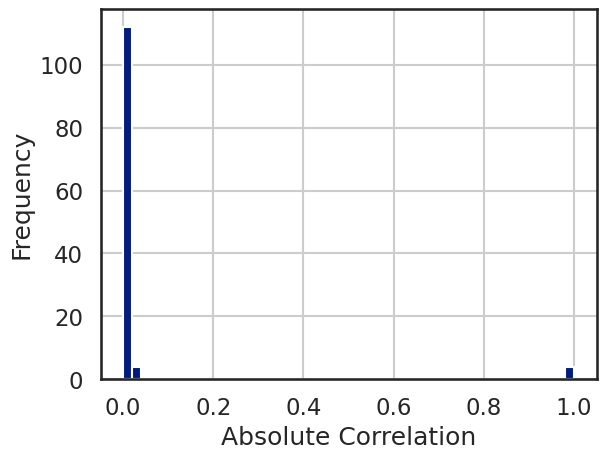

In [ ]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [ ]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
43,total_day_minutes,total_day_charge,1.000000,1.000000
76,total_eve_minutes,total_eve_charge,1.000000,1.000000
100,total_night_minutes,total_night_charge,0.999999,0.999999
115,total_intl_minutes,total_intl_charge,0.999993,0.999993


## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [ ]:
# Combine all the coefficients into a dataframe for comparison
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming you have trained models and X_train, y_train data
models = []  # List to store trained models
# Train your models and append them to the `models` list

# Example code for training a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
models.append(model)

# Plotting coefficients
fig, axs = plt.subplots(len(models), 1, figsize=(10, 6 * len(models)))
if len(models) == 1:
    axs = [axs]  # Ensuring axs is a list for single plot case

for idx, model in enumerate(models):
    if hasattr(model, 'coef_'):  # Check if the model has coefficients
        coef_abs = np.abs(model.coef_)
        axs[idx].bar(range(len(coef_abs)), coef_abs)
        axs[idx].set_xlabel('Feature Index')
        axs[idx].set_ylabel('Absolute Coefficient Value')
        axs[idx].set_title('Coefficients for Model {}'.format(idx + 1))
    else:
        axs[idx].set_title('Model {} does not have coefficients'.format(idx + 1))

plt.tight_layout()
plt.show()


Prepare six separate plots for each of the multi-class coefficients.

In [ ]:
# try the plots

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model.

In [ ]:
# Predict the class and the probability for each


## Question 12

For each model, calculate the following error metrics:

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [ ]:
# Calculate the error metrics as listed above

In [ ]:
#Run the metrics

## Question 13

Display or plot the confusion matrix for each model.

Confusion matrix, without normalization
[[4 1]
 [1 4]]
Normalized confusion matrix
[[0.8 0.2]
 [0.2 0.8]]


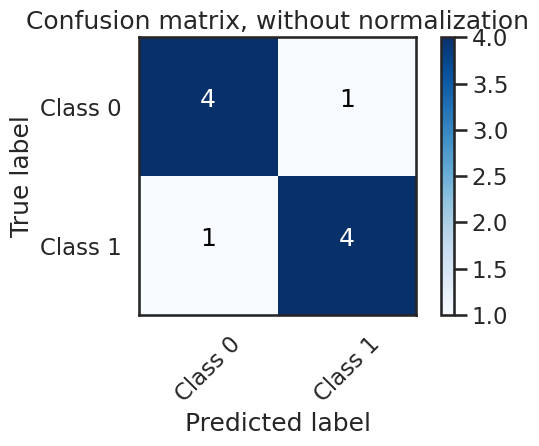

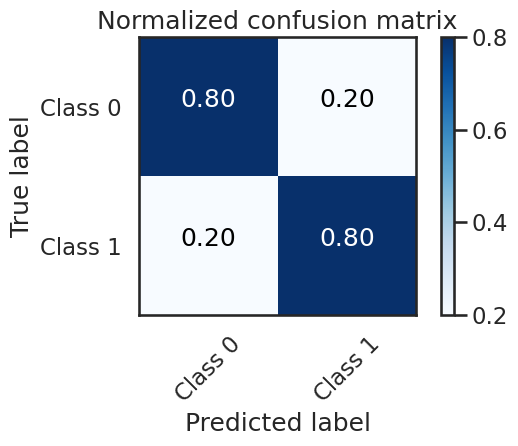

In [122]:
#plot the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Assuming y_true are the true labels and y_pred are the predicted labels
# Replace them with your actual true and predicted labels
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
y_pred = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'], normalize=True, title='Normalized confusion matrix')

plt.show()
